In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/translating-images-into-maps


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import cv2

In [3]:
import os
from pathlib import Path

from collections import namedtuple, Counter
import itertools

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import BoxVisibility

In [4]:
from src.data.dataloader import nuScenesMaps, read_split

In [5]:
data_root = Path.resolve(Path('./nuscenes_data/'))
nusc = NuScenes(version='v1.0-mini', dataroot=data_root, verbose=False)

In [6]:
Args = namedtuple('Args', ['root', 
                           'train_split', 
                           'grid_size', 
                           'grid_res', 
                           'load_classes_nusc', 
                           'data_size', 
                           'desired_image_size'])


z_range = [1.0, 9.0, 21.0, 39.0, 51.0]
grid_size = (z_range[-1] - z_range[0], z_range[-1] - z_range[0])

classes = [
    "drivable_area",
    "ped_crossing",
    "walkway",
    "carpark_area",
    "road_segment",
    "lane",
    "bus",
    "bicycle",
    "car",
    "construction_vehicle",
    "motorcycle",
    "trailer",
    "truck",
    "pedestrian",
    "trafficcone",
    "barrier",
]
data_root = os.path.join(os.getcwd(), 'nuscenes_data')
args = Args(root= data_root, # translating-images-into-maps/nuscenes_data
            train_split='train_mini',            # ground truth name
            grid_size=grid_size,                 # width and depth of validation grid, in meters
            grid_res=0.5,                        # size of grid cells, in meters
            load_classes_nusc=classes,           # Classes to load for NuScenes
            data_size=0.2,                       # percentage of dataset to train on
            desired_image_size=[1600, 900]       #size images are padded to before passing to network
           )
train_data = nuScenesMaps(
        root=args.root,
        split=args.train_split,
        grid_size=args.grid_size,
        grid_res=args.grid_res,
        classes=args.load_classes_nusc,
        dataset_size=args.data_size,
        desired_image_size=args.desired_image_size,
        mini=True,
        gt_out_size=(100, 100),
    )
tokens = read_split(
            os.path.join(data_root, "splits", "{}.txt".format('train_mini'))
        )

/Users/deepakduggirala/miniforge3/envs/tim/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835428/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
def color_components(labels, color_map):
    '''
    label 0 is assigned white color to have a white background.

    Iterates through the image to replace each pixel with the color associated with its label.

    Returns the colored image.
    '''
    colors = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)
    # unique_labels = np.unique(labels)
    # color_map = {l: np.random.choice(range(256), size=3) for l in unique_labels}  # assign random color to each label
    # color_map[0] = np.array([255, 255, 255])  # white background

    n_rows, n_cols = labels.shape
    for i in range(n_rows):
        for j in range(n_cols):
            colors[i, j, :] = color_map.get(labels[i, j], np.array([255, 255, 255]))

    return colors

class_labels = ['drivable_area', 'ped_crossing', 'walkway', 
                'carpark_area', 'bus', 'bicycle', 'car', 
                'construction_vehicle', 'motorcycle', 'trailer', 
                'truck', 'pedestrian', 'trafficcone', 'barrier']
color_map_labels = {
    'drivable_area': np.array([160, 160, 160]), 
     'ped_crossing': np.array([0, 153, 0]), 
     'walkway'     : np.array([0, 102, 204]), 
     'carpark_area': np.array([96, 96, 96]), 
     'bus'         : np.array([255, 128, 0]), 
     'bicycle'     : np.array([255, 55, 255]), 
     'car'         : np.array([255, 255, 51]), 
     'construction_vehicle': np.array([153, 0, 76]), 
     'motorcycle'  : np.array([255, 55, 255]), 
     'trailer'     : np.array([204, 0, 0]), 
     'truck'       : np.array([255, 102, 102]), 
     'pedestrian'  : np.array([51, 51, 255]), 
     'trafficcone' : np.array([255, 204, 153]), 
     'barrier'     : np.array([64, 64, 64])
}
color_map = {(i+1):color for i,color in enumerate(color_map_labels.values())}

In [8]:
def plot_input_ouput(i_sample, render_lidar=True, out_path=None, dpi=300):
    image, cls_maps, vis_mask, calib, grid2d = train_data.__getitem__(i_sample)
    
    composite = np.zeros((100,100), dtype=np.uint8)
    for i in range(len(class_labels)):
        img = cls_maps[i].numpy().astype(np.uint8)
        img_flipped = cv2.flip(img, 0)
        mask = img_flipped.astype(bool)
        composite[mask] = i+1
    colors = color_components(composite, color_map)
    
    sample = nusc.get('sample', tokens[i_sample])
    lidar_token = sample['data']['LIDAR_TOP']
    cam_front_token = sample['data']['CAM_FRONT']
    
    if render_lidar:
        fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(15,15))
        nusc.render_sample_data(cam_front_token, box_vis_level=BoxVisibility(0), verbose=False, ax=axs[0][0])
        nusc.render_sample_data(lidar_token, nsweeps=10, underlay_map=False, box_vis_level=BoxVisibility(0), verbose=False, ax=axs[0][1])
        ax = axs[1][0]
    else:
        fig, axs = plt.subplots(nrows = 1, ncols=2, figsize=(15, 15))
        nusc.render_sample_data(cam_front_token, box_vis_level=BoxVisibility(0), verbose=False, ax=axs[0])
        ax = axs[1]
    ax.imshow(colors)
    ax.set_title('BEV - ground truth')
    legend_colors = [np.append(c/255, 1) for c in color_map.values()]
    patches = [mpatches.Patch(color=legend_colors[i], label=label ) 
               for i, label in enumerate(color_map_labels.keys())]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    ax.axis('off')

    ## access each axes object via axs.flat
    for ax in axs.flat:
        ## check if something was plotted 
        if not bool(ax.has_data()):
            fig.delaxes(ax) ## delete if nothing is plotted in the axes obj

    fig.tight_layout()
    if out_path:
        fig.savefig(out_path, dpi=dpi)

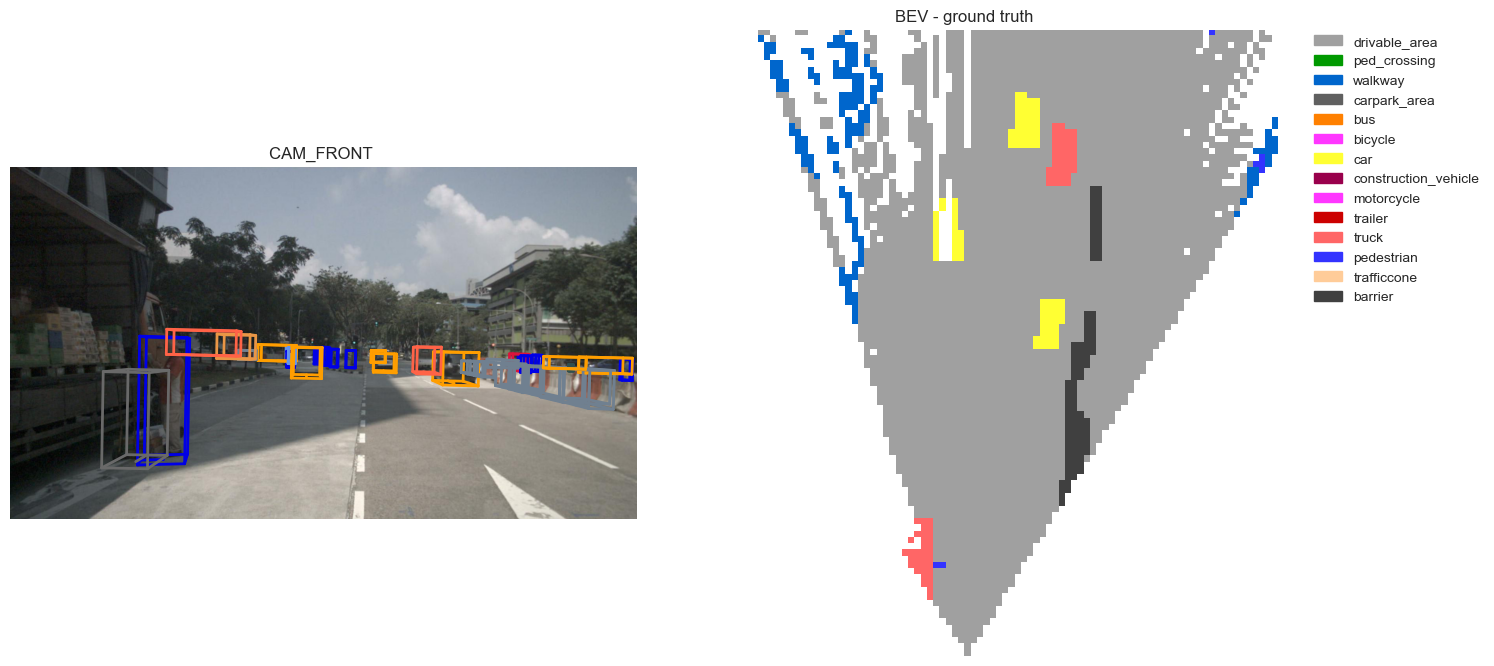

In [9]:
plot_input_ouput(i_sample=2, render_lidar=False)

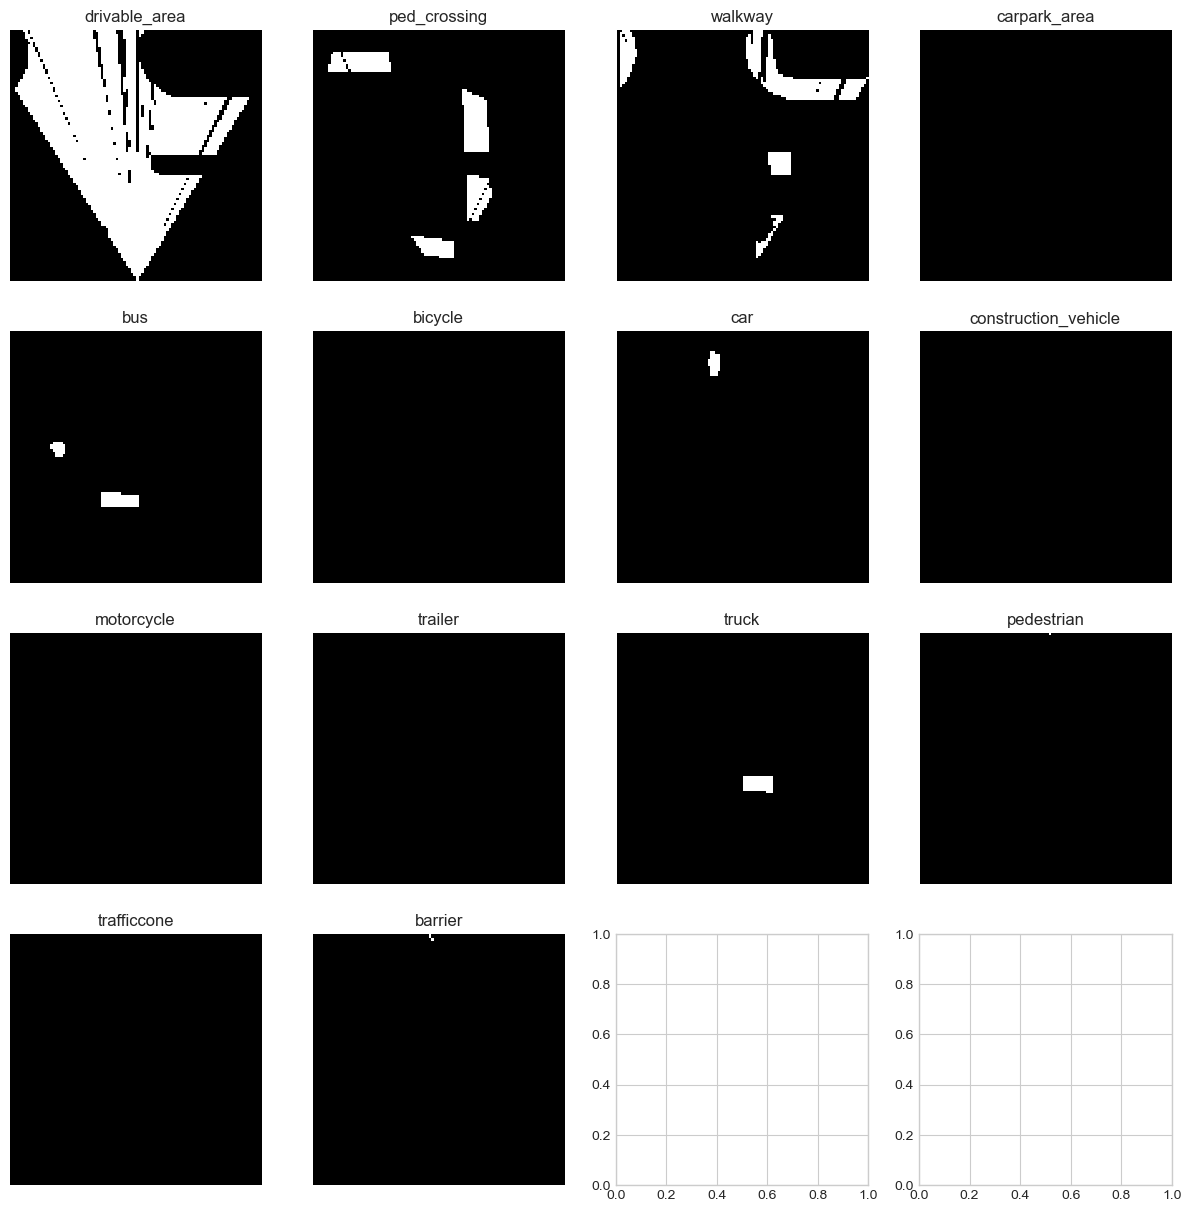

In [84]:
fig, ax = plt.subplots(nrows = 4, ncols=4, figsize=(15,15))

for i in range(4):
    for j in range(4):
        k = i*4+j
        if k < cls_maps.shape[0]:
            img = cls_maps[k].numpy().astype(np.uint8)
            img_flipped = cv2.flip(img, 0)
            ax[i][j].imshow(img_flipped, cmap='gray', interpolation='none')
            ax[i][j].set_title(class_labels[k])
            ax[i][j].axis('off')